## Normalizing flows

let's learn a mapping between two normal distrubutions

In [7]:
import abc
from typing import Tuple

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch import distributions as dist
from torch.distributions.distribution import Distribution
from torch import nn, optim

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class Flow(nn.Module, metaclass=abc.ABCMeta):
    """
    An abstract flow class.
    Derived classes must implement the :meth:`forward` and :meth:`inverse` methods.
    """

    def __init__(self, size: int, base: Distribution):
        super().__init__()

        self.size = size
        self.base = base

    @abc.abstractmethod
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Should apply the flow to a tensor of samples from the source distribution.
        """

    @abc.abstractmethod
    def inverse(self, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Shoud compute the inverse of the given tensor :code:`y`.
        
        :return: inverse and log(det inverse))
        """

    def sample(self, shape: Tuple[int, ...]) -> torch.Tensor:
        """
        Sample from the source distribution and apply the flow to the samples.
        """
        x = self.base.sample(shape)
        return self(x)

    def log_prob(self, y: torch.Tensor) -> torch.Tensor:
        """
        Compute logits of the given tensor.
        """
        x, logdet = self.inverse(y)
        return base.log_prob(x) + logdet

In [3]:
class LinearFlow(Flow):
    """
    Basically an affine flow.
    """

    def __init__(self, size: int, base: Distribution):
        super().__init__(size, base)
        self.linear = nn.Linear(size, size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)

    def inverse(self, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        batch = y.shape[0]
        inverse_weight = torch.inverse(self.linear.weight)
        return (
            F.linear(y - self.linear.bias, inverse_weight),
            torch.log(inverse_weight.det().abs().expand(batch)),
        )

In [4]:
# > take one normal distribution as the base distribution
base = dist.MultivariateNormal(
    torch.tensor([0.0, 0.0]), torch.tensor([[1, 0.0], [0, 1]])
)
linear_flow = LinearFlow(2, base)

optimizer = optim.Adam(linear_flow.parameters())

# > take another normal as the target distrubution
target = dist.MultivariateNormal(
    torch.tensor([10.0, 10.0]), torch.tensor([[1, 0.0], [0, 1]])
)

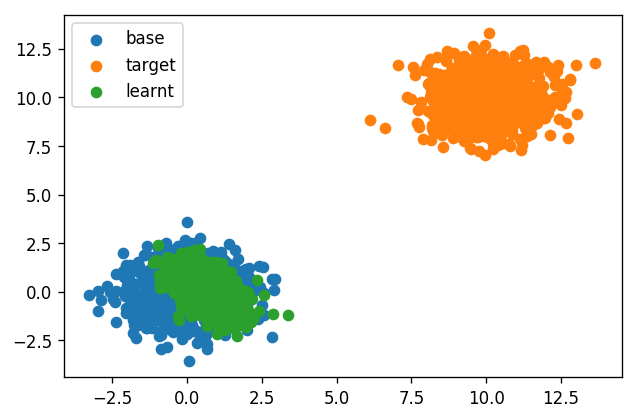

In [5]:
plt.figure(dpi=120)
y = base.sample([1000])
plt.scatter(y.data.numpy().T[0], y.data.numpy().T[1], label="base")

y = target.sample([1000])
plt.scatter(y.data.numpy().T[0], y.data.numpy().T[1], label="target")

y = linear_flow.sample([1000])
plt.scatter(y.data.numpy().T[0], y.data.numpy().T[1], label="learnt")
plt.legend()

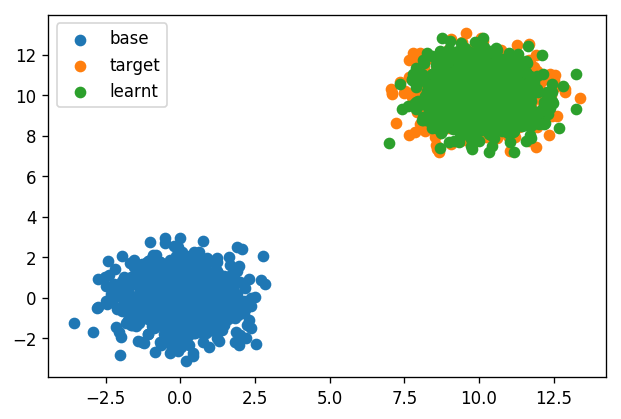

In [6]:
from IPython.display import clear_output

for epoch in range(20000):
    optimizer.zero_grad()

    y = target.sample([1000])
    # minimize -log p(data)
    loss = -linear_flow.log_prob(y).mean()
    loss.backward()

    optimizer.step()

    if epoch % 500 == 0:
        clear_output()

        plt.figure(dpi=120)
        y = base.sample([1000])
        plt.scatter(y.data.numpy().T[0], y.data.numpy().T[1], label="base")

        y = target.sample([1000])
        plt.scatter(y.data.numpy().T[0], y.data.numpy().T[1], label="target")

        y = linear_flow.sample([1000])
        plt.scatter(y.data.numpy().T[0], y.data.numpy().T[1], label="learnt")

        plt.legend()
        plt.show()

In [149]:
from torchvision.transforms import ToTensor

device = torch.device("cuda")

mnist_trainset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

mnist_testset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

In [150]:
import numpy as np

class MNISTDistribution(Distribution):

    def __init__(self, data, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data = data
    
    def rsample(self, shape):
        return self.data[np.random.randint(0, len(mnist_trainset))][0].to(device).view(28 ** 2)

In [180]:
base = dist.MultivariateNormal(
    torch.zeros(28 ** 2).to(device), torch.eye(28 ** 2).to(device)
)

mlf = LinearFlow(28 ** 2, base).to(device)

optimizer = optim.Adam(mlf.parameters())

target = MNISTDistribution(mnist_trainset)

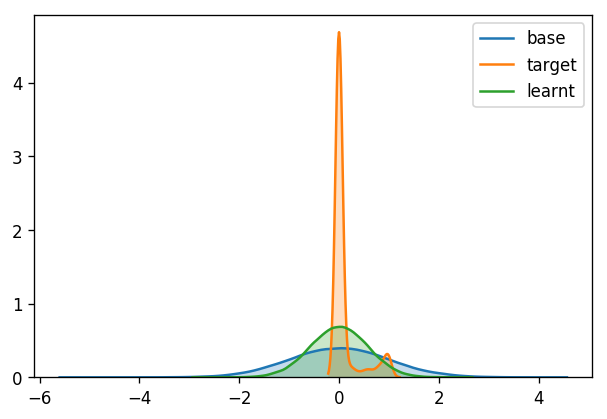

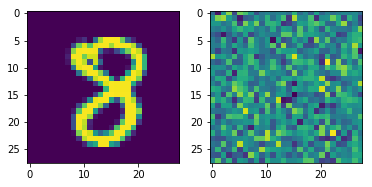

In [167]:
import seaborn as sns

plt.figure(dpi=120)
y = base.sample([100])
sns.kdeplot(y.data.cpu().numpy().flatten(), shade=True, label="base")

y = target.sample([100])
sns.kdeplot(y.data.cpu().numpy(), shade=True, label="target")

y = mlf.sample([100])
sns.kdeplot(y.data.cpu().numpy().flatten(), shade=True, label="learnt")
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(target.sample([1]).reshape((28, 28)).cpu().numpy(), label="Target")
ax[1].imshow(mlf.sample([1]).reshape((28, 28)).detach().cpu().numpy(), label="Learnt")

ValueError: array must not contain infs or NaNs

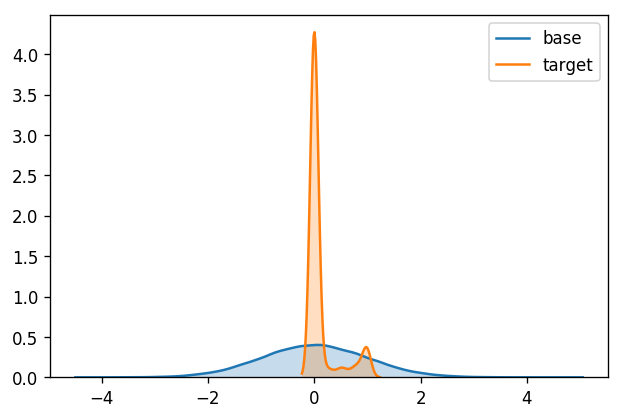

In [168]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

batch_size = 32

for epoch in tqdm(range(len(target.data) // batch_size + batch_size)):
    optimizer.zero_grad()

    y = target.sample([batch_size])
    # minimize -log p(data)
    loss = -mlf.log_prob(y).mean()
    loss.backward()

    optimizer.step()

    if epoch % 50 == 0:
        #clear_output()

        plt.figure(dpi=120)
        y = base.sample([100])
        sns.kdeplot(y.data.cpu().numpy().flatten(), shade=True, label="base")

        y = target.sample([100])
        sns.kdeplot(y.data.cpu().numpy(), shade=True, label="target")

        y = mlf.sample([100])
        sns.kdeplot(y.data.cpu().numpy().flatten(), shade=True, label="learnt")
        plt.legend()
        plt.show()

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(target.sample([1]).reshape((28, 28)).cpu().numpy(), label="Target")
        ax[1].imshow(mlf.sample([1]).reshape((28, 28)).detach().cpu().numpy(), label="Learnt")
        plt.show()

In [ ]:
def log_prob(self, y: torch.Tensor) -> torch.Tensor:
    """
    Compute logits of the given tensor.
    """
    x, logdet = self.inverse(y)
    return base.log_prob(x) + logdet

In [ ]:
inverse_weight = torch.inverse(self.linear.weight)
return (
    F.linear(y - self.linear.bias, inverse_weight),
    torch.log(inverse_weight.det().abs().expand(1)),
)

In [235]:
# mlf(mlf.base.sample([1]))
#mlf.log_prob()
#target.sample([1])
#F.linear(y - mlf.linear.bias, mlf.linear.weight.inverse())
#torch.log(mlf.linear.weight.inverse().det().abs().expand(1)

y = target.sample([1])  # shape == 724

(
    mlf.linear.weight  # shape == (724, 724)
    #.inverse()
    .det()
)

tensor(0., device='cuda:0', grad_fn=<DetBackward>)